# Simulation with photovoltaic system (3 kW)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import poisson
from joblib import Parallel, delayed
import time
import sys
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar

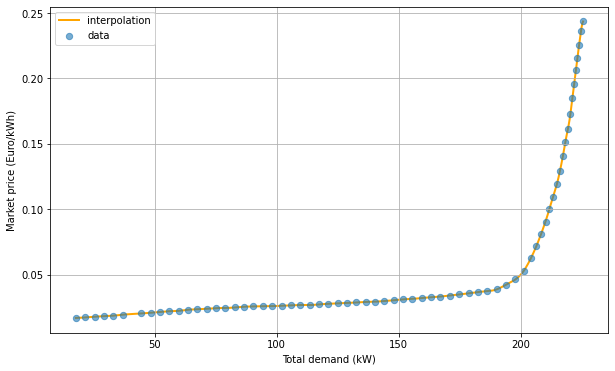

In [2]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 100 - 210

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 600)
plt.figure(figsize=(10,6))
plt.plot(x, market_price(x), lw=2, label='interpolation', c='orange', zorder=0)
plt.scatter(tot_demand, market_price_data[:, 1] / 1000, s=40, label='data', zorder=1, alpha=0.6)
plt.xlabel('Total demand (kW)')
plt.ylabel('Market price (Euro/kWh)')
plt.legend()
plt.grid()

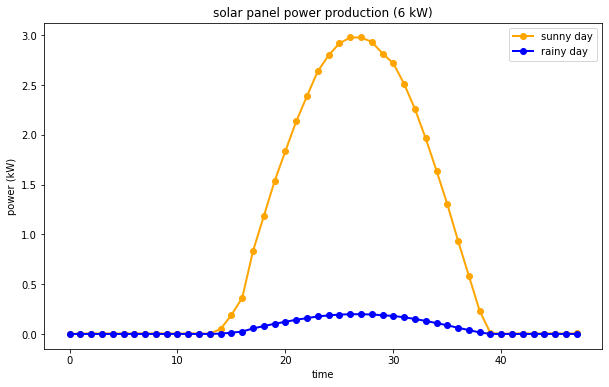

In [3]:
# import photovoltaic system power profiles
s = pd.read_csv('data/panel_power.csv', delimiter=',', usecols=[1,2,3,4])
plt.figure(figsize=(10,6))
plt.xlabel('time')
plt.ylabel('power (kW)')
plt.title('solar panel power production (6 kW)')
plt.plot(s.time*2, s.sunny, '-o', c='orange', lw=2, label='sunny day')
plt.plot(s.time*2, s.rainy, '-o', c='blue', lw=2, label='rainy day')
plt.legend();

### Functions

In [4]:
# Customer's utility function: for optimizing wrt b_pm
def u(b_pm, p, l, s):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    s: power supply from energy generators 
    
    """
    return np.sum(p * (b_pm[:T] - alpha * b_pm[T:] + l - s))

def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        #mat1[0, j] = -alpha
        mat1[0, j] = -1
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        #mat4[i, :i] = -alpha
        #mat4[i, T:T+i] = alpha
        mat4[i, :i] = -1
        mat4[i, T:T+i] = 1
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5])

def constr_vectors_b(b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [e0] * T, [e - e0] * T])
    return leftv_constr, rightv_constr

def optimize_b(f, b_sup, b_inf, p, alpha, e0, e, l, x0, s):
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    b_opt = minimize(f, x0, args=(p, l, s), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        options={'verbose' : 0})
    return b_opt.x

In [5]:
# import load profiles
load_curve_tot = np.load('data/load_agg_pred.npy')

### Parameters

In [6]:
n_nodes = 100   # total number of consumers
n_smart = 30    # consumers with storage and renewable energy
T = 48          # number of time slots in a day(1 slot = 0.5 hours)
n_days = 100     # number of days to simulate 
beta = 0.05     # storage profile learning rate
b_inf = 0.2     # maximum discharge in a time slot (kWh)
b_sup = 0.2     # maximum charge in a time slot(kWh)
alpha = 0.8     # efficiency
e = 5.          # storage capacity
sigma = 0.05

weather = 'sunny'

# generate load profiles
l = np.ndarray(shape=(0, T))
for i in range(n_nodes):
    l = np.append(l, [load_curve_tot[i*T:(i+1)*T]], axis=0)

## Aware customers

In [7]:
# Intialization
e0 = np.zeros(n_smart)                                            # storage level
b_pm = np.zeros(shape=(n_smart, 2*T))                             # charging profiles
b_history = np.ndarray(shape=(0, n_smart, T))                              # storage profile history
p_history = np.ndarray(shape=(0, T))                              # price history

p = market_price(l.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
u_history = np.ndarray(shape=(0, n_smart))
x0 = np.zeros(shape=(n_smart, 2*T))
l_day = np.zeros(shape=(n_nodes, T))                              # daily load profiles

### Simulation

In [8]:
for d in range(n_days):
    t_start = time.time()
    b_opt = np.ndarray(shape=(0, 2*T))
    
    # generate load profile
    for i in range(n_nodes):
        l_day[i, :] = l[i,(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma
    
    # optimize b
    with Parallel(n_jobs=n_smart) as parallel:
        b_opt_list = parallel(delayed(optimize_b)\
                              (u, b_sup, b_inf, p, alpha, e0[n],
                               e, l_day[n, :], x0[n], s[weather]) for n in range(n_smart))
    for n in range(n_smart):
        b_opt = np.append(b_opt, [b_opt_list[n]], axis=0)

    # update b
    b_pm = b_pm + beta * (b_opt - b_pm)
    x0 = b_opt

    # update e0
    e0 = e0 + b_pm[:, :T].sum() - b_pm[:, T:].sum()

    b_history = np.append(b_history, [b_pm[:, :T] - b_pm[:, T:]], axis=0)
    p = market_price(l_day.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0) - n_smart * s[weather])
    p_history = np.append(p_history, [p], axis=0)
    u_history = np.append(u_history, [[u(b_pm[n, :], p, l_day[n, :], s[weather]) for n in range(n_smart)]], axis=0)
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))

completed day 1/100 in 0.19 min
completed day 2/100 in 0.14 min
completed day 3/100 in 0.14 min
completed day 4/100 in 0.14 min
completed day 5/100 in 0.14 min
completed day 6/100 in 0.14 min
completed day 7/100 in 0.14 min
completed day 8/100 in 0.15 min
completed day 9/100 in 0.15 min
completed day 10/100 in 0.14 min
completed day 11/100 in 0.15 min
completed day 12/100 in 0.15 min
completed day 13/100 in 0.14 min
completed day 14/100 in 0.13 min
completed day 15/100 in 0.14 min
completed day 16/100 in 0.13 min
completed day 17/100 in 0.12 min
completed day 18/100 in 0.13 min
completed day 19/100 in 0.13 min
completed day 20/100 in 0.13 min
completed day 21/100 in 0.14 min
completed day 22/100 in 0.13 min
completed day 23/100 in 0.13 min
completed day 24/100 in 0.14 min
completed day 25/100 in 0.14 min
completed day 26/100 in 0.13 min
completed day 27/100 in 0.13 min
completed day 28/100 in 0.13 min
completed day 29/100 in 0.14 min
completed day 30/100 in 0.14 min
completed day 31/10

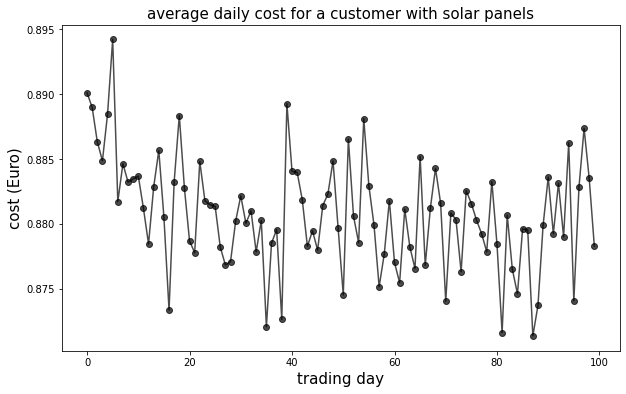

In [9]:
plt.figure(figsize=(10,6))
plt.title('average daily cost for a customer with solar panels', size=15)
plt.xlabel('trading day', size=15)
plt.ylabel('cost (Euro)', size=15)
plt.plot(u_history.mean(axis=1), '-o', c='black', alpha=0.7);

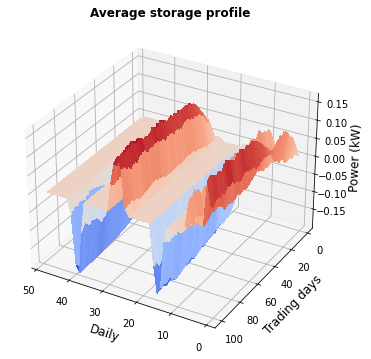

In [10]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history.mean(axis=1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Power (kW)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Average storage profile', size=12, fontweight='bold');

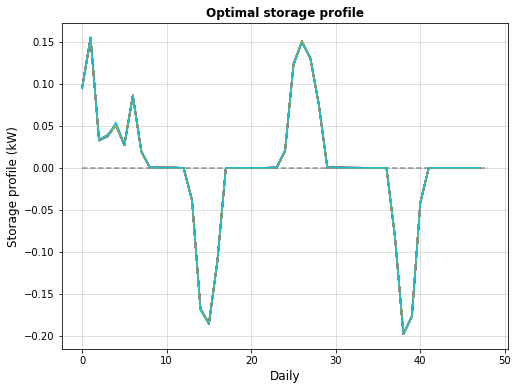

In [15]:
plt.figure(figsize=(8,6))
plt.xlabel('Daily', size=12)
plt.ylabel('Storage profile (kW)', size=12)
plt.title('Optimal storage profile', size=12, fontweight='bold')
plt.hlines(xmin=0, xmax=48, y=0., ls='dashed', color='black', alpha=0.4)
#plt.plot(b_history.mean(axis=1)[-1], '-o', c='black', alpha=0.8);
for i in range(n_smart):
    plt.plot(b_history[-1, i, :])
plt.grid(alpha=0.5)

NameError: name 'load_curve' is not defined

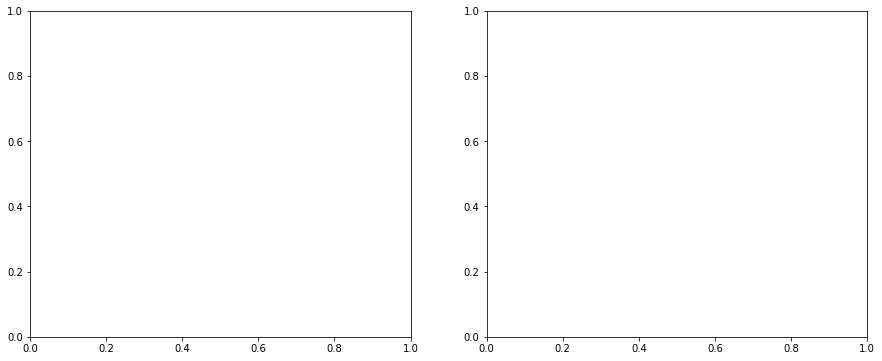

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
t = np.arange(T)

cost_smart = p_history[-1, :] * (b_history[-1, :] + load_curve - s[weather])
ax[0].set_title('cost of energy for a smart user')
ax[0].set_xlabel('daily hour')
ax[0].set_ylabel('cost (Euro)')
ax[0].plot(t, cost_smart, '-o', c='red', alpha=0.7)
ax[0].grid(alpha=0.5)

cost_normal = p_history[-1, :] * load_curve
ax[1].set_title('cost of energy for a normal user')
ax[1].set_xlabel('daily hour')
ax[1].set_ylabel('cost (Euro)')
ax[1].plot(t, cost_normal, '-o', c='blue', alpha=0.7)
ax[1].grid(alpha=0.5)

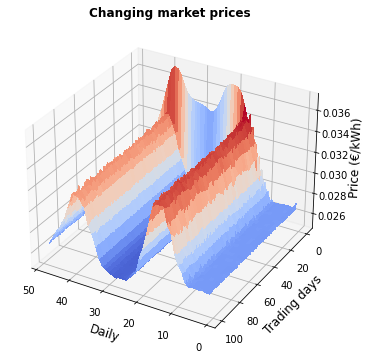

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Price (€/kWh)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Changing market prices', size=12, fontweight='bold');

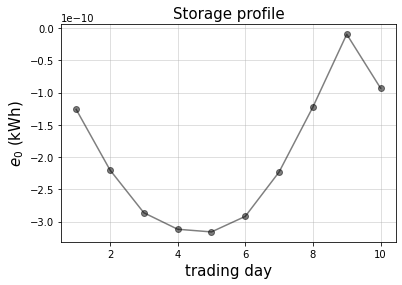

In [35]:
e0 = np.cumsum(b_history.sum(axis=1))
plt.plot(np.arange(1,n_days+1,1), e0, '-o', c='black', alpha=0.5)
plt.title('Storage profile', size=15)
plt.ylabel(r'$e_0$ (kWh)', size=15)
plt.xlabel('trading day', size=15);
plt.grid(alpha=0.5)

In [14]:
np.save('Results/b_history-{w}-{dd}d.npy'.format(w=weather, dd=n_days), b_history)
np.save('Results/p_history-{w}-{dd}d.npy'.format(w=weather, dd=n_days), p_history)
np.save('Results/u_history-{w}-{dd}d.npy'.format(w=weather, dd=n_days), u_history)